In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error

df = pd.read_csv('./project_data/sms_spam.csv',delimiter=',',encoding='UTF-8')
df.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Bernoulli Naive Bayes Classifier

In [2]:
X = pd.DataFrame(df['text'])
Y = pd.DataFrame(df['type'])
X_train_raw, X_test_raw, y_train, y_test = train_test_split(df.text,df.type,test_size=0.2,random_state = 0)

In [3]:
le = LabelEncoder()

Y_train = le.fit_transform(y_train)

Y_test = le.fit_transform(y_test)

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train_raw)

In [4]:
classifier = BernoulliNB()
classifier.fit(X_train, Y_train)

X_test = vectorizer.transform(X_test_raw)
predictions = classifier.predict(X_test)
#print(predictions)
print ('Accuracy is {}'.format(classifier.score(X_test, Y_test)))

y_pred = pd.DataFrame(predictions)
print('MSE: {}'.format(mean_squared_error(Y_test, y_pred)))
      
comat = confusion_matrix(Y_test, y_pred)
#comat = confusion_matrix(y_pred,y_test)

print('confusion matrix:\n {}'.format(comat))

print(classification_report(Y_test, y_pred, target_names=['ham', 'spam']))

Accuracy is 0.9730941704035875
MSE: 0.026905829596412557
confusion matrix:
 [[949   1]
 [ 29 136]]
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       950
        spam       0.99      0.82      0.90       165

    accuracy                           0.97      1115
   macro avg       0.98      0.91      0.94      1115
weighted avg       0.97      0.97      0.97      1115



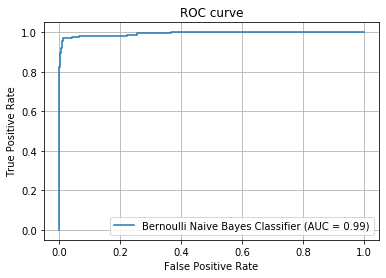

In [5]:
y_predicted_bernoulli = classifier.predict_proba(X_test)[:, 1]

fpr_bernoulli, tpr_bernoulli, thresholds_logistic = metrics.roc_curve(Y_test, y_predicted_bernoulli)

auc_bernoulli = metrics.auc(fpr_bernoulli, tpr_bernoulli)

plt.plot(fpr_bernoulli, tpr_bernoulli, label='Bernoulli Naive Bayes Classifier (AUC = %.2f)'%auc_bernoulli)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

## Using the cross-validation

## Since I changed the scikit-learn to use the cross-validation, if you implement the following code, please change your _validation.py (sklearn/model_selection/_validation.py) to _validation.py I provided.

In [2]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression 

In [3]:
X_row = df.text.values.tolist()
y_row = df.type.values.tolist()

vectorizer = TfidfVectorizer()
data = vectorizer.fit_transform(X_row)

le = LabelEncoder()

label = le.fit_transform(y_row)

classifier = BernoulliNB()

kfold = StratifiedKFold(n_splits=5, shuffle = True, random_state = 0)

In [4]:
scores = cross_val_score(classifier, data, label, cv=kfold)

print("Cross-validation scores: {}".format(scores["results"]))
print("Average cross-validation score: {}".format(scores["results"].mean()))
print("MSE: {}".format(scores["mse"]))
print("Average MSE: {}".format(scores["mse"].mean()))

Cross-validation scores: [0.98744395 0.9793722  0.9793722  0.97488789 0.98294434]
Average cross-validation score: 0.9808041155775253
MSE: [0.01255605 0.0206278  0.0206278  0.02511211 0.01705566]
Average MSE: 0.01919588442247466


In [5]:
for i in range(len(scores["conf"])):
    print("Confusion matrix" + str(i+1) + ":\n{}".format(scores["conf"][i]))

Confusion matrix1:
[[966   0]
 [ 14 135]]
Confusion matrix2:
[[964   2]
 [ 21 128]]
Confusion matrix3:
[[963   2]
 [ 21 129]]
Confusion matrix4:
[[958   7]
 [ 21 129]]
Confusion matrix5:
[[963   2]
 [ 17 132]]


In [6]:
for i in range(len(scores["class_report"])):
    report = pd.DataFrame(scores["class_report"][i])
    report = report.rename(columns={'0': 'ham', '1': 'spam'})
    print("Classification Report" + str(i+1) + ":\n{}\n".format(report))

Classification Report1:
                  ham        spam  accuracy    macro avg  weighted avg
precision    0.985714    1.000000  0.987444     0.992857      0.987623
recall       1.000000    0.906040  0.987444     0.953020      0.987444
f1-score     0.992806    0.950704  0.987444     0.971755      0.987180
support    966.000000  149.000000  0.987444  1115.000000   1115.000000

Classification Report2:
                  ham        spam  accuracy    macro avg  weighted avg
precision    0.978680    0.984615  0.979372     0.981648      0.979473
recall       0.997930    0.859060  0.979372     0.928495      0.979372
f1-score     0.988211    0.917563  0.979372     0.952887      0.978770
support    966.000000  149.000000  0.979372  1115.000000   1115.000000

Classification Report3:
                  ham        spam  accuracy    macro avg  weighted avg
precision    0.978659    0.984733  0.979372     0.981696      0.979476
recall       0.997927    0.860000  0.979372     0.928964      0.979372
f1-

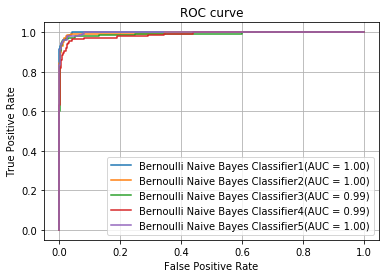

In [7]:
for i in range(len(scores["prob"])):
    # calculate FPR, TPR
    fpr_bernoulli, tpr_bernoulli, thresholds_lbernoulli = metrics.roc_curve(scores["prob"][i][1], scores["prob"][i][0][:,1])

    # calculate AUC
    auc_bernoulli = metrics.auc(fpr_bernoulli, tpr_bernoulli)

    # plot ROC curves
    plt.plot(fpr_bernoulli, tpr_bernoulli, label='Bernoulli Naive Bayes Classifier' + str(i+1) + '(AUC = %.2f)'%auc_bernoulli)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    #plt.show()
    plt.savefig('ROC_naive_bayes.png')